In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sys

In [2]:
d_cols = ['Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
train_test_ratio = 0.75
data = pd.read_csv('/home/fakerpbc/data/ToyotaCorolla.csv', sep=',', names=d_cols, encoding='latin-1')

In [3]:
data_dict = data.as_matrix()
X0 = np.delete(data_dict, 0, 0)

# mapping 
tmp = {'Diesel':1, 'Petrol':2, 'CNG':3}
for i in range(len(X0[:, 3])):
    X0[i, 3] = tmp[X0[i, 3]]
# for i in range(50):
#     print(X0[i, :])
    
data_X = X0.astype('float32')
n_data = len(data_X)
n_train = int(n_data*train_test_ratio)
n_test = n_data - n_train
print(n_data)
print('n_train : ', n_train)
print('n_test : ', n_test)

train_numbers = np.random.choice(n_data, n_train, replace=False)
test_numbers = np.array(list(set(range(n_data)) - set(train_numbers)))

X_train = data_X[train_numbers, 1:]
Y_train = data_X[train_numbers, 0]

X_test = data_X[test_numbers, 1:]
Y_test = data_X[test_numbers, 0]

max_Price = np.maximum(np.max(Y_train.astype('int')), np.max(Y_test.astype('int')))
min_Price = np.minimum(np.min(Y_train.astype('int')), np.min(Y_test.astype('int')))

Y_test = np.reshape(Y_test, (-1, 1))
print(X_test.shape)
print(Y_test.shape)
# print(Y_test)
dimesion = X_train.shape[1]

1436
n_train :  1077
n_test :  359
(359, 9)
(359, 1)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [4]:
def normalize(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min)/(col_max-col_min)

x_trains = np.nan_to_num(normalize(X_train))
x_tests = np.nan_to_num(normalize(X_test))
y_trains = np.nan_to_num(normalize(Y_train))
y_tests = np.nan_to_num(normalize(Y_test))
print(x_trains.shape)
print(y_trains.shape)
print(x_tests.shape)
print(y_tests.shape)
#print(y_tests)

(1077, 9)
(1077,)
(359, 9)
(359, 1)


In [5]:
X = tf.placeholder(tf.float32, shape=[None, dimesion], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 1], name='Y')

w = tf.Variable(tf.zeros((dimesion, 1)))
    
b = tf.Variable([0.])
    
pred = tf.add(tf.matmul(X, w), b)
#print(pred)
x_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=Y)
y_pred = tf.sigmoid(pred)
result = y_pred*(max_Price - min_Price) + min_Price
loss = tf.reduce_mean(x_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

In [6]:
init = tf.global_variables_initializer()
epochs  = 30
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        for xt, yt in zip(x_trains, y_trains):
            xt = np.reshape(xt, (-1, dimesion))
            yt = np.reshape(yt, (-1, 1))
            sess.run(optimizer, feed_dict={X:xt, Y:yt})
        if i % 10 ==0:
            print('loss epochs '+str(i)+' : ', sess.run(loss, feed_dict={X:xt, Y:yt})) 
    
    w_out, b_out = sess.run([w, b])
    print('w : ', w_out)
    print('b : ', b_out)

    print(sess.run(loss, feed_dict={X:x_tests, Y:y_tests, w:w_out, b:b_out}))
    print()
    p_results = sess.run(result, feed_dict={X:x_tests, Y:y_tests, w:w_out, b:b_out})
    #print(sess.run(result, feed_dict={X:x_tests, Y:y_tests, w:w_out, b:b_out}))
    #print(p_results)

loss epochs 0 :  0.5633439
loss epochs 10 :  0.5633265
loss epochs 20 :  0.5633321
w :  [[-1.9070985 ]
 [-1.0518633 ]
 [-0.35969764]
 [ 0.9879714 ]
 [ 0.03049137]
 [ 0.05094402]
 [-0.21701252]
 [ 0.01735837]
 [ 1.8384115 ]]
b :  [0.01779595]
0.50689834



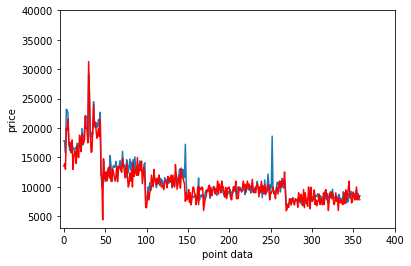

In [8]:
import matplotlib.pyplot as plt
x = np.array(range(y_tests.shape[0]))
plt.xlabel('point data')
plt.ylabel('price')
plt.axis([-5, 400, 3000, 40000])
plt.plot(x, p_results[x])
plt.plot(x, Y_test,'r')
plt.show()